In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [2]:
import SimpleITK as sitk


In [3]:
from typing import List, Tuple
import torch
import hydra
import omegaconf
import numpy as np
from omegaconf import DictConfig
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import Logger
from tqdm import tqdm
# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)
from src.data.bvisa_dm import CS_Dataset
import src.utils.default as utils
import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('medium')

## Else

In [4]:
from dotenv import load_dotenv

load_dotenv(Path.cwd().parent/'.env')

True

In [5]:
log = utils.get_pylogger(__name__)

EVAL_PATH = '../logs/test_orig_full_left_downs/runs/2023-02-21_13-22-19/.hydra'
CHKPT_PATH = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs/test_folds_orig_noignore/runs/2023-02-20_14-45-42/checkpoints/last.ckpt'

device = 'cuda:0'

In [7]:
cfg = omegaconf.OmegaConf.load(EVAL_PATH + '/config.yaml')

FileNotFoundError: [Errno 2] No such file or directory: '/home/vladyslavz/git/central-sulcus-analysis/logs/test_orig_full_left_downs/runs/2023-02-21_13-22-19/.hydra/config.yaml'

In [7]:
cfg.ckpt_path = CHKPT_PATH

log.info(f"Instantiating datamodule <{cfg.data._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)

log.info(f"Instantiating model <{cfg.model._target_}>")
model: LightningModule = hydra.utils.instantiate(cfg.model).to(device)

# # log.info("Instantiating loggers...")
# # logger: List[Logger] = utils.instantiate_loggers(cfg.get("logger"))

# log.info(f"Instantiating trainer <{cfg.trainer._target_}>")
# trainer: Trainer = Trainer(gpus=1, max_epochs=1, logger=False)


BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).


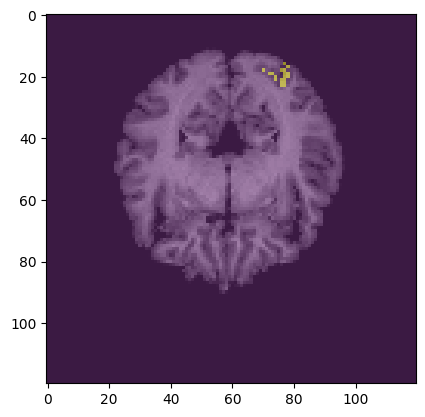

In [9]:
for batch in datamodule.train_dataloader():
    image = batch['image']
    target = batch['target']
# plt.imshow(image[0, 0, 80, :, :], cmap='gray')
# plt.show()
# plt.imshow(target[0, 0, 80, :, :], cmap='gray')
# plt.show()

    plt.imshow(image[0, 0, 40, :, :], cmap='gray', alpha=0.8)
    # plt.show()
    plt.imshow(target[0, 40, :, :], alpha=0.5)
    plt.show()
    break

In [12]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49, 50, 51, 53, 55,
       56, 57, 58, 59, 60, 61, 62, 63])

In [9]:
# make prediction
with torch.no_grad():
    pred_proba = model(image.to(device))


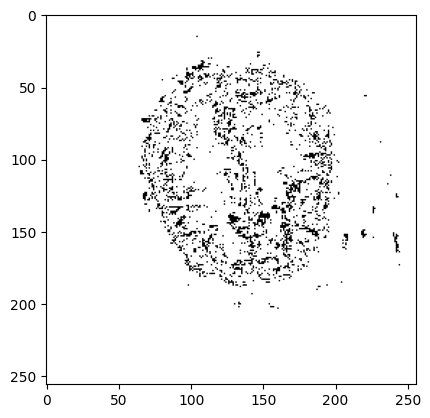

In [10]:
pred = pred_proba.cpu().numpy()
pred = np.argmax((pred[0, :, : :, :]), axis=0)
sliecnum = 85
plt.imshow(pred[sliecnum, :, :], cmap='gray')

## Checking inputs

In [5]:
from src.data.bvisa_dm import CS_Dataset

d1 = CS_Dataset(dataset='bvisa', split='validation', images='folds', target='sulci', dataset_path='/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa')
d2 = CS_Dataset(dataset='bvisa', split='validation', images='skull_stripped', target='sulci', dataset_path='/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa')

eros


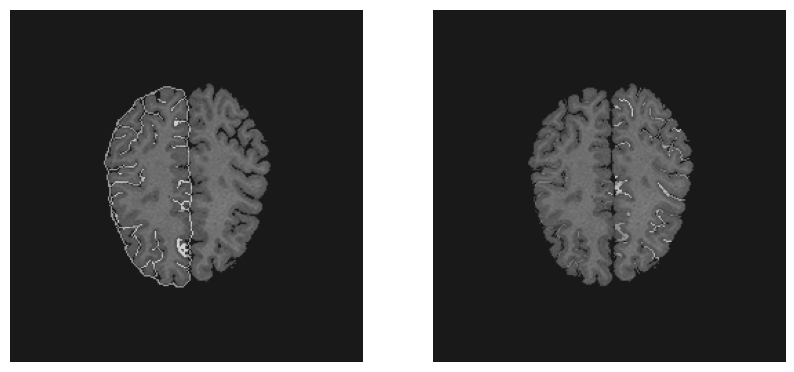

In [6]:
for i in range(len(d1)):
    d1_s = d1[i]
    d2_s = d2[i]
    assert d1_s['caseid'] == d2_s['caseid']
    print(d1_s['caseid'])
    folds = d1_s['image']
    image = d2_s['image']
    gt = d2_s['target']
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image[0, 80, :, :], cmap='gray', alpha=0.8)
    ax[0].imshow(folds[0, 80, :, :], cmap='gray', alpha=0.5)
    ax[0].set_axis_off()
    ax[1].imshow(image[0, 80, :, :], cmap='gray', alpha=0.8)
    ax[1].imshow(gt[80, :, :], cmap='gray', alpha=0.5)
    ax[1].set_axis_off()
    plt.show()
    break

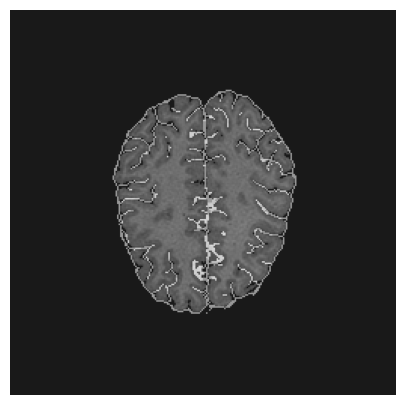

In [8]:
d3 = CS_Dataset(dataset='bvisa', split='validation', images='skull_stripped', target='folds', dataset_path='/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa')
d3_s = d3[0]
image = d3_s['image']
gt = d3_s['target']
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(image[0, 80, :, :], cmap='gray', alpha=0.8)
ax.imshow(gt[80, :, :], cmap='gray', alpha=0.5)
ax.set_axis_off()

## Checking outputs and loss

In [9]:
from src.models.unet3d.model import UNet3D

In [13]:
model = UNet3D(in_channels=1, out_channels=2, final_sigmoid=False, f_maps=(16, 32, 64, 128))

image_batch = torch.unsqueeze(folds, dim=0)

In [14]:
output = model(image_batch)

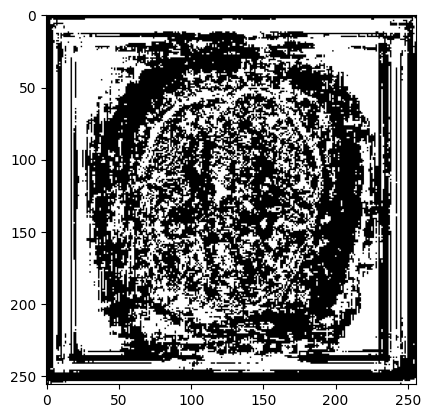

In [15]:
output_bin = torch.argmax(output, dim=1)
plt.imshow(output_bin[0, 80, :, :], cmap='gray')

In [16]:
from torch.nn import CrossEntropyLoss

In [17]:
loss = CrossEntropyLoss()

In [18]:
image_batch.shape

torch.Size([1, 1, 124, 256, 256])

In [ ]:
loss(output, torch.unsqueeze(target, dim=0))

In [19]:
gt.shape

torch.Size([124, 256, 256])

In [20]:
np.unique(gt.numpy())

array([0, 1])

In [25]:
target = torch.unsqueeze(gt, dim=0)

In [22]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [26]:
target.shape

torch.Size([1, 124, 256, 256])

In [29]:
loss_val = loss(output, target)
print(loss_val)

tensor(0.6577, grad_fn=<NllLoss2DBackward0>)


In [54]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [55]:
mask.shape

torch.Size([1, 1, 124, 256, 256])

In [64]:
mask = image_batch!=0

y_hat_masked = output[:,:,mask[0][0]]
y_masked = target[mask[0]]

In [65]:
y_hat_masked.shape

torch.Size([1, 2, 143973])

In [66]:
y_masked.shape

torch.Size([143973])

In [71]:
target[:, mask[0][0]].shape

torch.Size([1, 143973])

## Checking Dice Metrics

In [35]:
output_bin = torch.argmax(output, dim=1)

In [33]:
output_bin.shape

torch.Size([2, 124, 256, 256])

In [34]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [36]:
from torchmetrics import Dice

In [37]:
dice_score = Dice(num_classes=2, ignore_index=0)
dice_score(output, target)

tensor(0.0006)

In [41]:
dice_score = Dice(num_classes=2, ignore_index=0)
dice_score(output_bin, target)

tensor(0.0006)

In [38]:
dice_score = Dice(num_classes=2)
dice_score(output, target)

tensor(0.6505)

In [ ]:
in

In [43]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [11]:
lsucs = sitk.ReadImage('/mrhome/vladyslavz/Downloads/base62_2019/all/ammon/t1mri/t1/default_analysis/folds/3.3/base2018_manual/segmentation/LSulci_ammon_base2018_manual.nii.gz')

In [13]:
{x:idx-1 for idx, x in enumerate(np.unique(sitk.GetArrayFromImage(lsucs)))}

{0: -1,
 1: 0,
 3: 1,
 4: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18,
 21: 19,
 22: 20,
 23: 21,
 24: 22,
 25: 23,
 26: 24,
 27: 25,
 28: 26,
 29: 27,
 30: 28,
 31: 29,
 32: 30,
 33: 31,
 34: 32,
 35: 33,
 36: 34,
 37: 35,
 38: 36,
 39: 37,
 40: 38,
 41: 39,
 42: 40,
 43: 41,
 44: 42,
 45: 43,
 46: 44,
 47: 45,
 48: 46,
 49: 47,
 50: 48,
 51: 49,
 52: 50,
 53: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62}

In [32]:
non_zeros = np.stack(np.nonzero(image.numpy())).T
x_min, y_min, z_min = non_zeros.min(0)
x_max, y_max, z_max = non_zeros.max(0)
non_zeros_image = image[:, :, x_min:x_max, y_min:y_max, z_min:z_max]

TypeError: cannot unpack non-iterable numpy.int64 object

In [34]:
non_zeros.min(0)

array([ 0,  0,  6, 23, 63])

In [22]:
non_zeros.max(0)[0]

tensor([  0,   0, 120, 188, 206])

In [31]:
np.stack(np.nonzero(image.numpy())).T

array([[  0,   0,   6,  49, 106],
       [  0,   0,   6,  49, 110],
       [  0,   0,   6,  49, 113],
       ...,
       [  0,   0, 120, 142, 149],
       [  0,   0, 120, 142, 150],
       [  0,   0, 120, 143, 148]])

In [12]:
image_shapes = []
target_shapes = []

for batch in datamodule.train_dataloader():
    img = batch['image']
    img = torch.squeeze(img, dim=0)
    image_shapes.append(img.shape)
    target_shapes.append(batch['target'].shape)
    
    if img.shape != batch['target'].shape:
        print(batch['caseid'], img.shape, batch['target'].shape)

In [15]:
from src.utils.general import resample_volume

In [16]:
img  = sitk.ReadImage('/mrhome/vladyslavz/Downloads/base62_2019/all/ammon/t1mri/t1/ammon.nii.gz')

Text(0.5, 1.0, 'Resampled image shape: (120, 120, 74)')

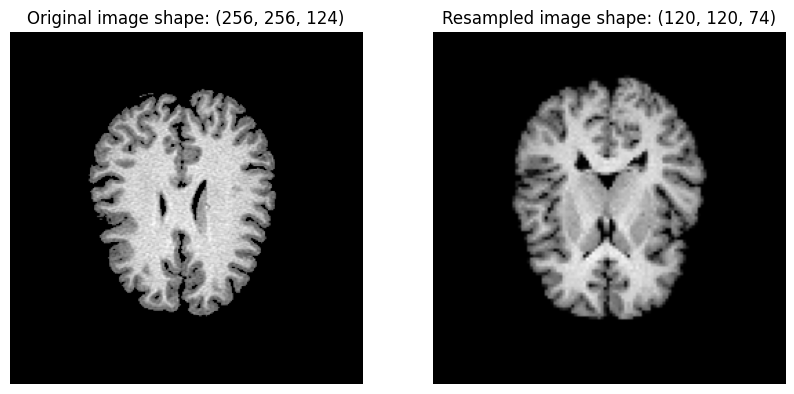

In [22]:
img_resampled = resample_volume(img, new_spacing=(2, 2, 2))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sitk.GetArrayFromImage(img)[80, :, :], cmap='gray')
axs[0].set_axis_off()
axs[0].set_title(f'Original image shape: {img.GetSize()}')

axs[1].imshow(sitk.GetArrayFromImage(img_resampled)[40, :, :], cmap='gray')
axs[1].set_axis_off()
axs[1].set_title(f'Resampled image shape: {img_resampled.GetSize()}')

In [26]:
def crop_image_to_content(image:np.array):
    """ Crops image to content (non-zero voxels) """
    non_zeros = np.stack(np.nonzero(image)).T
    x_min, y_min, z_min = non_zeros.min(0)
    x_max, y_max, z_max = non_zeros.max(0)
    return image[x_min:x_max, y_min:y_max, z_min:z_max]     

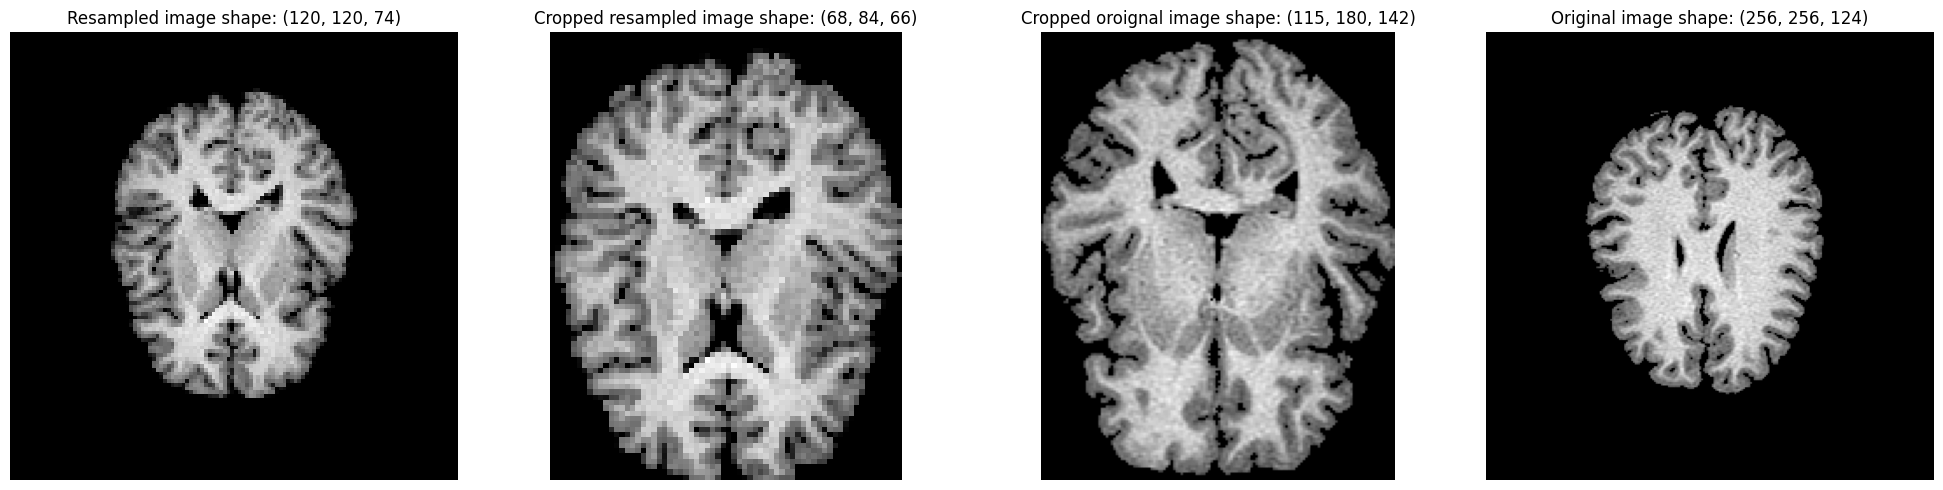

In [32]:
img_cropped = crop_image_to_content(sitk.GetArrayFromImage(img_resampled))
img_cropped_orig = crop_image_to_content(sitk.GetArrayFromImage(img))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(sitk.GetArrayFromImage(img_resampled)[40, :, :], cmap='gray')
axs[0].set_axis_off()
axs[0].set_title(f'Resampled image shape: {img_resampled.GetSize()}')

axs[1].imshow(img_cropped[40, :, :], cmap='gray')
axs[1].set_axis_off()
axs[1].set_title(f'Cropped resampled image shape: {img_cropped.shape}')


axs[2].imshow(img_cropped_orig[60, :, :], cmap='gray')
axs[2].set_axis_off()
axs[2].set_title(f'Cropped oroignal image shape: {img_cropped_orig.shape}')

axs[3].imshow(sitk.GetArrayFromImage(img)[80, :, :], cmap='gray')
axs[3].set_axis_off()
axs[3].set_title(f'Original image shape: {img.GetSize()}')
plt.tight_layout()
plt.show()

## Drafts

In [4]:
dl = CS_Dataset('bvisa',
                'train',
                'sulci_skeletons',
                'right_sulci',
                '/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa',
                resample=None,
                crop2content=True,
                preload=False,
                transforms='rotate',
                padd2same_size=True)

In [5]:
shapes = []
for img in range(len(dl)):
    shapes.append(dl[img]['image'].shape)
    break

In [11]:
a = dl[2]['image'][0, 80, :, :]
b = dl[2]['image'][0, 80, :, :]

In [6]:
np.stack(shapes).max(0)

array([  1, 160, 224, 192])

In [19]:
labels = []
for o in tqdm(dl.target_paths):
    img = sitk.ReadImage(str(o[0]))
    labels.extend(np.unique(sitk.GetArrayFromImage(img)))

100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


In [20]:
np.unique(labels)

array([  0,  63,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 131,
       132, 133, 135], dtype=int16)

In [21]:
len(np.unique(labels))

68

In [15]:
np.unique(labels)

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64, 125,
       126, 129, 130, 134, 136, 137, 138, 139], dtype=int16)

In [17]:
len(np.unique(labels))

73

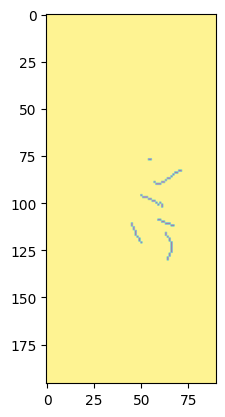

In [21]:
for i in range(len(dl)):
    batch = dl[i]
    sl= 80
    image = batch['image']
    target = batch['target']
    # plt.imshow(image[0, sl, :, :], cmap='gray', alpha=0.8)
    # plt.show()
    plt.imshow(target[sl, :, :]==0, alpha=0.5)
    plt.show()
    break

In [19]:
print(torch.unique(target, return_counts=True))
print(torch.unique(image, return_counts=True))

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), tensor([1461588,     691,     108,     478,      75,    1385,     637,     451,
            349,     903,     495,    1199,     684,    1460,    1644,     142,
            465,     658,     574,    1258,     671,     893,     362,     217,
             18,     110,     209,     744,     236,     590,    1939,    2734,
            193,     166,     349,     829,     547,    2160,     227,     751,
            248,     795,     215,    1719,     221,    1382,     399,    1226,
            308,      82,      67,    1009,      45,      89,      63,     125,
            115,     838,     313,     151,     338,     170,      71,     222]))
(tensor([0., 1.]), tensor([1422548,   76852]))


In [32]:
Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa/anubis/t1mri/t1/anubis.nii.gz').exists()

True

In [34]:
dl.img_paths[0]

[[PosixPath('/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa/anubis/t1mri/t1/anubis.nii.gz')]]

In [5]:
from src.data.splits import bvisa_left_sulci_labels, bvisa_right_sulci_labels, bvisa_sulci_names

In [8]:
len(set(bvisa_sulci_names))

64